<a id="index">Index</a>

1. [Encoding and Transformation](#Encoding-and-Transformation)
2. [Grid Search](#Grid-Search)
3. [Scores](#Scores)
4. [Comparison of the two models](#Comparison-of-the-two-models)

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


from sklearn.preprocessing import MinMaxScaler, StandardScaler
mmScaler = MinMaxScaler()
stdScaler = StandardScaler()


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from sklearn.pipeline import make_pipeline


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score,\
                            recall_score, precision_score, plot_roc_curve,\
                            precision_recall_curve, plot_precision_recall_curve,\
                            f1_score


import re, os

from itertools import product

import pickle, json


DEFAULT_RANDOM_STATE = 786

In [2]:
def plotConfusionMatrix(estimator, x, y_true):
    check_preds = estimator.predict(x)

    cm = confusion_matrix(y_true, check_preds)
    plt.rcParams["font.size"] = 10
    cm_display = ConfusionMatrixDisplay(cm).plot()

    plt.xticks(ticks=[0,1], labels=["Active", "Resigned"])
    plt.yticks(ticks=[0,1], labels=["Active", "Resigned"])
    plt.show()

    roc    = roc_auc_score(y_true, check_preds)
    recall = recall_score(y_true, check_preds)
    preci  = precision_score(y_true, check_preds)
    acc    = accuracy_score(y_true, check_preds)

    print(f"{'ROC':<11}: {roc:.4f}\n{'Recall':<11}: {recall:.4f}\n{'Precision':<11}: {preci:.4f}\n{'Accuracy':<11}: {acc:.4f}")

In [3]:
def threshold_score(estimator, x_data, y_true, threshold = 0.5, plot_matrix = True, return_scores = None):
    check_preds = estimator.predict_proba(x_data)[:, 0]
    check_preds = (check_preds < threshold).astype(int)

    cm     = confusion_matrix(y_true, check_preds)
    roc    = roc_auc_score(y_true, check_preds)
    recall = recall_score(y_true, check_preds)
    preci  = precision_score(y_true, check_preds)
    acc    = accuracy_score(y_true, check_preds)
    f1     = f1_score(y_true, check_preds)
    bth    = bestThreshold(*roc_curve(y_true, check_preds))
    
    results = {
        "cm" : cm,
        "roc": roc,
        "recall": recall,
        "precision": preci,
        "acc": acc,
        "f1": f1,
        "bth": bth
    }
    
    if type(return_scores)==list:
        scores = []
        for score in return_scores:
            if results.get(score, None) is None:
                raise "Wrong score name"
            
            scores.append(results[score])
        return scores
    
    if plot_matrix:
        plt.rcParams["font.size"] = 10
        cm_display = ConfusionMatrixDisplay(cm).plot()
        plt.xticks(ticks=[0,1], labels=["Active", "Resigned"])
        plt.yticks(ticks=[0,1], labels=["Active", "Resigned"])
        plt.show()


    print(f"{'ROC':<11}: {roc:.4f}\n{'Recall':<11}: {recall:.4f}\n{'Precision':<11}: {preci:.4f}\n{'Accuracy':<11}: {acc:.4f}")


def bestThreshold(fprs, tprs, thresholds):
    gmeans = np.sqrt(tprs*(1-fprs))
    
    return thresholds[np.argmax(gmeans)]

In [4]:
df = pd.read_csv("Final_for_model.csv")
df.head()

,Employee No,Employee Name,Gender,Leaving Reason,Previous Employer,Latest Available Rating,Profit Center,Employee Location,People Group,Employee Category,Supervisor name,Month of termination,Tenure_till_18,Tenure_till_18_in_months,Tenure_till_18_in_years,Age_16_18,Current Status16_18,Is promoted,Total Hours,Total Available Hours,Work Hours,Leave Hours,Training Hours,BD Hours,NC Hours,Utilization%,Utilization Status,Utilization%-Mean
0,1,Rochette Jilleen,Unknown,Unknown,Unknown,Unknown,PC - 1,Location 3,Client Service Staff,SVP/VP,Idalina Lauraine,Unknown,17.497964,209.975564,17.0,0.0,Active,Yes,4168.0,3666.5,1084.0,404.0,97.5,2623.5,74.0,29.661004,Below Avg,29.661004
1,2,Daryl Natalina,Unknown,Unknown,Unknown,Unknown,PC - 2,Location 7,Client Service Staff,SVP/VP,Idalina Lauraine,Unknown,18.834062,226.008748,19.0,0.0,Active,No,4168.0,3750.0,1277.5,364.0,54.0,1294.5,1330.5,34.083718,Below Avg,34.083718
2,3,Annnora Gabrielle,Unknown,Unknown,Unknown,Unknown,PC - 2,Location 7,Client Service Staff,SVP/VP,Idalina Lauraine,Unknown,17.161201,205.934413,17.0,0.0,Active,No,4168.0,3618.5,2177.5,482.0,67.5,970.5,907.0,60.553933,Above Avg,60.553933
3,4,Barbee Joey,M,Career Growth,kadoo,Unknown,PC - 3,Location 1,Client Service Staff,Awaiting Termination,Idalina Lauraine,2,17.413089,208.957063,17.0,43.0,Resigned,No,3928.0,3491.5,546.0,404.0,32.5,2743.0,279.0,15.695026,Low,15.695026
4,5,Idalina Lauraine,Unknown,Unknown,Unknown,Unknown,PC - 4,Location 3,Client Service Staff,Level 1/2,Abagail Druci,Unknown,18.751925,225.023101,19.0,0.0,Active,No,1312.0,1205.0,149.0,104.0,3.0,1159.0,818.0,12.365145,Low,12.365145


In [5]:
drop_cols = [
    "Employee No"
    , "Employee Name"
    , "Previous Employer"
    , "People Group"
    , "Employee Category"
    , "Supervisor name"
    , "Tenure_till_18_in_months"
    , "Tenure_till_18_in_years"
    , "Utilization Status"
    , "Employee Location"
    , "Gender"
    , "Leaving Reason"
    , "Latest  Available Rating"
    , "Tenure_till_18"
    , "Age_16_18"
    , "BD Hours"
    , "Month of termination"
]

provisional_cols = [
    "dummy"
#     , "Utilization%"
    , "Utilization%-Mean"
#     , 'Total Available Hours'
#     , 'Total Hours'
#     , 'Work Hours'
#     , 'Leave Hours'
]

data = df.drop(drop_cols + provisional_cols[1:], axis=1)
data.head()

,Profit Center,Current Status16_18,Is promoted,Total Hours,Total Available Hours,Work Hours,Leave Hours,Training Hours,NC Hours,Utilization%
0,PC - 1,Active,Yes,4168.0,3666.5,1084.0,404.0,97.5,74.0,29.661004
1,PC - 2,Active,No,4168.0,3750.0,1277.5,364.0,54.0,1330.5,34.083718
2,PC - 2,Active,No,4168.0,3618.5,2177.5,482.0,67.5,907.0,60.553933
3,PC - 3,Resigned,No,3928.0,3491.5,546.0,404.0,32.5,279.0,15.695026
4,PC - 4,Active,No,1312.0,1205.0,149.0,104.0,3.0,818.0,12.365145


## [Encoding and Transformation](#index)

1. Resigned and Active are mapped to 1 and 0 respectively
2. Log Transformation is applied to `NC Hours` and `Leave Hours`, and power transformation to `Utilization%` (power = 1.3)

In [6]:
def profitCenterClub(row):
    pcnum = int(row["Profit Center"].split()[-1])
    
    if pcnum>3:
        return "Other"
    
    return row["Profit Center"]

data["ProfitCenter"] = data.apply(profitCenterClub, axis=1)
data.drop(["Profit Center"], axis=1, inplace=True)


### Splitting data into x(predictors) and y(target)
data_x = pd.get_dummies(data.drop(["Current Status16_18"], axis=1))
data_y = data["Current Status16_18"].map({"Active" : 0, "Resigned" : 1})



def logTrans(data, cols):
    for col in cols:
        data[col] = np.log(data[col]+1)

transform_cols = ["NC Hours", "Leave Hours"]
logTrans(data_x, transform_cols)


### Transforming the utilization% column using the below power based on the resulting distribution in EDA
util_transform_power = 1.3
data_x["Utilization%"] = data_x["Utilization%"].transform(lambda s: s**(1/util_transform_power))
data_x.head()

,Total Hours,Total Available Hours,Work Hours,Leave Hours,Training Hours,NC Hours,Utilization%,Is promoted_No,Is promoted_Yes,ProfitCenter_Other,ProfitCenter_PC - 1,ProfitCenter_PC - 2,ProfitCenter_PC - 3
0,4168.0,3666.5,1084.0,6.003887,97.5,4.317488,13.565964,0,1,0,1,0,0
1,4168.0,3750.0,1277.5,5.899897,54.0,7.194061,15.096709,1,0,0,0,1,0
2,4168.0,3618.5,2177.5,6.180017,67.5,6.811244,23.489769,1,0,0,0,1,0
3,3928.0,3491.5,546.0,6.003887,32.5,5.634790,8.314133,1,0,0,0,0,1
4,1312.0,1205.0,149.0,4.653960,3.0,6.708084,6.920751,1,0,1,0,0,0


In [7]:
data_x["Utilization%"].skew(), data_x["Utilization%"].kurtosis()

(-0.003100560484439175, 12.536384371340938)

In [8]:
def scaleTheSplit(train_data, test_data, scaler, transform_train = False):
    scaler.fit(train_data)
    return_test  = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)
    
    if transform_train:
        return_train = pd.DataFrame(scaler.transform(train_data), columns=train_data.columns)
        return return_train, return_test

    return train_data, return_test

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2,
                                                    stratify=data_y,
                                                    random_state=DEFAULT_RANDOM_STATE)
x_train_scaled, x_test = scaleTheSplit(x_train, x_test, mmScaler, transform_train=True)

In [10]:
y_test.value_counts(normalize=True), y_train.value_counts(normalize=True)

(0    0.743243
 1    0.256757
 Name: Current Status16_18, dtype: float64,
 0    0.74605
 1    0.25395
 Name: Current Status16_18, dtype: float64)

## [Grid Search](#index)

In [11]:
model2 = DecisionTreeClassifier()
dt_params = {
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "criterion": ["gini", "entropy"],
    "max_features": ['sqrt', 'log2'],
    'class_weight': [{0: wt} for wt in np.linspace(0.1, 0.5, 5)], 
#     "min_samples_leaf": [3, 4, 5, 6, 7],
    "min_samples_split": [3, 4]
}
dt_gridcv = GridSearchCV(estimator = model2,
                         param_grid = dt_params,
                         cv = 5,
                         scoring = ["accuracy", "recall", "precision", "f1"],
                         refit = 'f1',
                         verbose = True,
                         return_train_score = True)
dt_gridcv.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{0: 0.1}, {0: 0.2},
                                          {0: 0.30000000000000004}, {0: 0.4},
                                          {0: 0.5}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [3, 4]},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'recall', 'precision', 'f1'], verbose=True)

In [12]:
dt_gridcv.cv_results_["mean_test_precision"].min(),\
dt_gridcv.cv_results_["mean_test_precision"].max(),\
dt_gridcv.cv_results_["mean_test_precision"].std()

(0.343242193694373, 0.6913351330870513, 0.06870921621566053)

In [13]:
dt_gridcv.cv_results_["mean_test_f1"].min(),\
dt_gridcv.cv_results_["mean_test_f1"].max(),\
dt_gridcv.cv_results_["mean_test_f1"].std()

(0.45728096329037893, 0.63861666458651, 0.02912302412240767)

In [14]:
dt_gridcv.best_params_

{'class_weight': {0: 0.5},
 'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'log2',
 'min_samples_split': 3}

In [15]:
dt_gridcv.best_score_

0.63861666458651

## [Scores](#index)

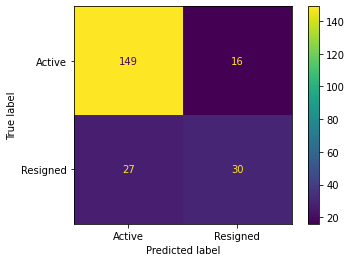

ROC        : 0.7147
Recall     : 0.5263
Precision  : 0.6522
Accuracy   : 0.8063


In [16]:
plotConfusionMatrix(dt_gridcv, x_test, y_test)

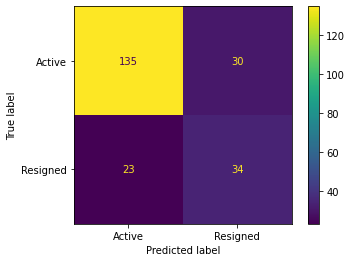

ROC        : 0.7073
Recall     : 0.5965
Precision  : 0.5312
Accuracy   : 0.7613


In [22]:
threshold_score(dt_gridcv, x_test, y_test, 0.6523)

### [Comparison of the two models](#index)

In [18]:
rf = pickle.load(open("Saved Models/rf#1.pkl", "rb"))

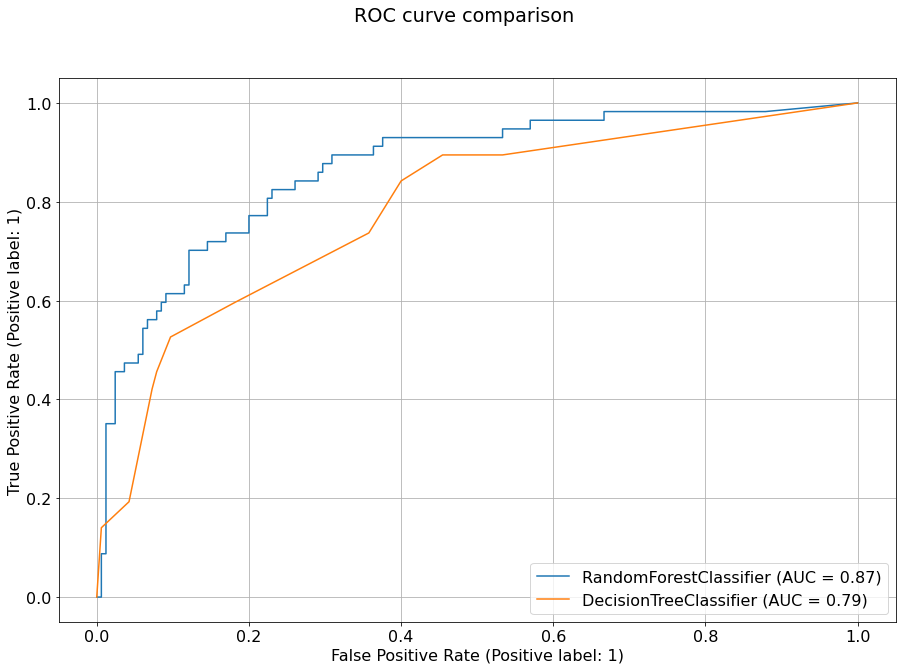

In [19]:
ticksize = 16
plt.rcParams["font.size"] = 16
fig = plot_roc_curve(rf, x_test, y_test)
fig = plot_roc_curve(dt_gridcv.best_estimator_, x_test, y_test, ax = fig.ax_)
fig.figure_.suptitle("ROC curve comparison")
fig.ax_.figure.set_size_inches(15,10)
fig.ax_.xaxis.label.set_fontsize(ticksize)
fig.ax_.yaxis.label.set_fontsize(ticksize)
fig.ax_.set_axisbelow(True)
plt.grid()
plt.show()

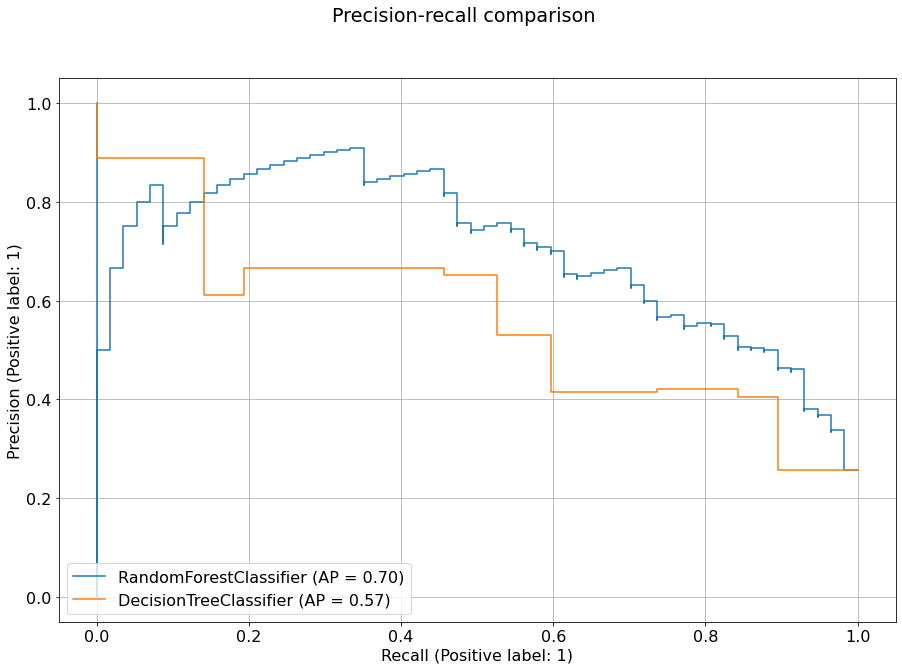

In [20]:
ticksize = 16
plt.rcParams["font.size"] = 16
fig = plot_precision_recall_curve(rf, x_test, y_test)
fig = plot_precision_recall_curve(dt_gridcv.best_estimator_, x_test, y_test, ax = fig.ax_)
fig.figure_.suptitle("Precision-recall comparison")
fig.ax_.figure.set_size_inches(15,10)
fig.ax_.xaxis.label.set_fontsize(ticksize)
fig.ax_.yaxis.label.set_fontsize(ticksize)
fig.ax_.set_axisbelow(True)
plt.grid()
plt.show()